Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@45-Image 1-20X_savedata0.pickle
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 2-20X_savedata5.pickle
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 1-20X_savedata3.pickle
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 2-20X_savedata6.pickle
Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 1-20X_savedata0.pickle


[]

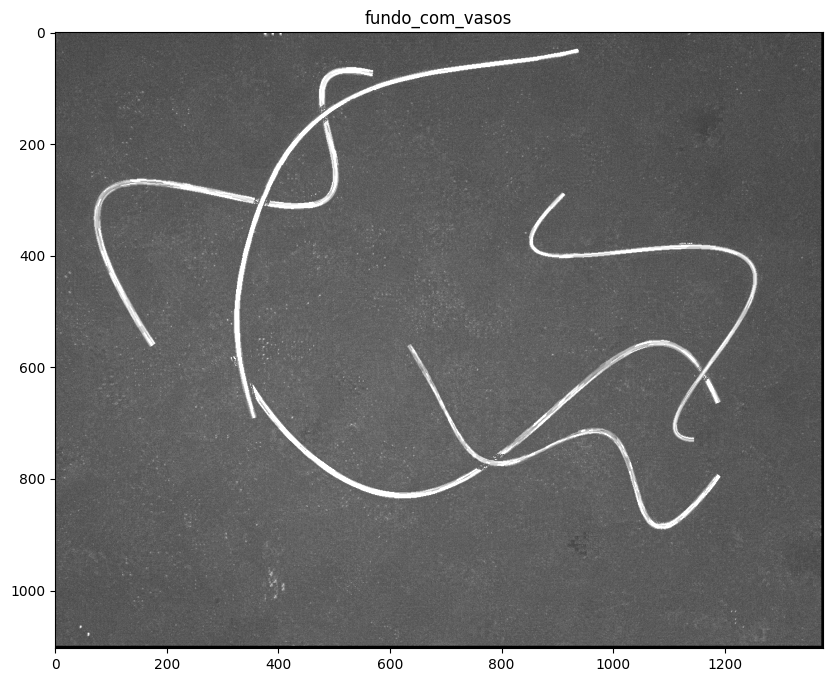

In [1]:
import pickle
import numpy as np
from PIL import Image
import skimage as ski
import sys, time
import geopandas as gpd
from matplotlib import pyplot as plt
from Image_properties import props

sys.path.insert(0, "/home/adriano/projeto_mestrado/modules")

from Funcoes_gerais import funcoes

import background_generation as backgen

root_dir = f"/home/adriano/projeto_mestrado/modules"

img_dir = f'{root_dir}/Imagens/vessel_data/images/'
lab_dir = f'{root_dir}/Imagens/vessel_data/labels_20x/'
pickle_dir = f'{root_dir}/Vessel_Models_pickle'
background_dir = f'{root_dir}/Background/Mapas_gerados_artificialmente'
tracados_dir = f'{root_dir}/Artificial_Lines/tracados_bezier'
#img_especifica = 'Experiment #1 (adults set #1)_20x_batch1 - Superficial layers@40-Image 3-20X'

array_pickles = funcoes.ler_diretorios(pickle_dir)
array_backgrounds = funcoes.ler_diretorios(background_dir)
array_tracados = funcoes.ler_diretorios(tracados_dir)

#np.random.seed(4)
n_backgrounds = np.random.randint(0, len(array_backgrounds))
n_tracados = np.random.randint(0, len(array_tracados))
tracado = array_tracados[n_tracados]

array_medial_path = backgen.retorna_paths(f'{tracados_dir}/{tracado}')

#back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))
back_artif = np.array(Image.open(f'{background_dir}/{array_backgrounds[n_backgrounds]}'))

vetor_informacoes = []
vetor_mapas_sem_artefatos = []
vetor_mapas_originais = []
vetor_vasos_sem_artefados = []
vetor_mask_map = []
vetor_mapas_originais_norm = []
vetor_mapas_originais_merge_norm_random = []
vetor_limiares1 = []
vetor_limiares2 = []
vetor_img_maps_final = []
vetor_mapa_original_hist = []
vetor_img_map_hist = []
vetor_img_map_transf = []

for i in range(len(array_medial_path)):
#for i in range(2):  
  n_random = np.random.randint(0, len(array_pickles))  
  
  path = (pickle_dir + f'/{array_pickles[n_random]}')
  print(f'{array_pickles[n_random]}')

  arquivo_pickle = pickle.load(open(path, 'rb')) 
  vessel_map = arquivo_pickle['vessel_model'].vessel_map 
  mapa_original = vessel_map.mapped_values
  
  imagem_binaria_original = vessel_map.mapped_mask_values 
  imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)
  
  imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais) 
  
  mapa_original_hist = backgen.histograma_matching(mapa_original,imagem_binaria_sem_artefatos_laterais,back_artif)
  
  rows, cols = mapa_original.shape  

  distancia = (rows/2) 
  
  limiar1 = backgen.encontrar_pixel_mais_frequente(mapa_original_hist)  
  
  limiar2 = backgen.encontrar_mediana_fundo_mapa(mapa_original_hist,imagem_binaria_sem_artefatos)
  
  mask_map_new = np.ones(mapa_original_hist.shape) 
  
  caminhos_transladados = backgen.retorna_caminhos_transladados(array_medial_path[i],0) # type: ignore 

  maior_valor = np.max(caminhos_transladados[0])
  
  mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original_hist,maior_valor) 
  
  vaso_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor)
 
 
  dict = {
      "path": path,
      "arquivo_pickle": arquivo_pickle,
      "vessel_map": vessel_map,
      "mapa_original": mapa_original,
      "imagem_binaria_original": imagem_binaria_original,
      "imagem_binaria_sem_artefatos_laterais": imagem_binaria_sem_artefatos_laterais,  
      "imagem_binaria_sem_artefatos": imagem_binaria_sem_artefatos,
      #"mapa_original_norm": mapa_original_norm,
      "mapa_original_hist":mapa_original_hist,
      #"mapa_original_merge_norm_random" : mapa_original_merge_norm_random,
      "caminhos_transladados": caminhos_transladados,
      "maior_valor": maior_valor,
      "mapa_expandido_original": mapa_expandido_original,
      "vaso_expandido_bin": vaso_expandido_bin,
      "rows": rows,
      "cols": cols,
      "distancia": distancia,
      "limiar1": limiar1,
      "limiar2": limiar2
    }
  vetor_informacoes.append(dict)

fundo_com_vasos1 = back_artif.copy()
possui_vasos = np.zeros_like(back_artif, dtype=np.uint8)
for i in range(len(array_medial_path)): 
#for i in range(2): 

    caminhos_transladados = vetor_informacoes[i]['caminhos_transladados'] # type: ignore
    maior_valor = vetor_informacoes[i]['maior_valor'] # type: ignore
    distancia = vetor_informacoes[i]['distancia'] # type: ignore
    mapa_original = vetor_informacoes[i]['mapa_original'] # type: ignore
    #mapa_original_norm = vetor_informacoes[i]['mapa_original_norm'] # type: ignore
    #mapa_original_merge_norm_random = vetor_informacoes[i]['mapa_original_merge_norm_random'] # type: ignore   
    mapa_original_hist = vetor_informacoes[i]["mapa_original_hist"] 
    imagem_binaria_sem_artefatos = vetor_informacoes[i]['imagem_binaria_sem_artefatos'] # type: ignore
    mapa_expandido_original = vetor_informacoes[i]['mapa_expandido_original'] # type: ignore
    vaso_expandido_bin = vetor_informacoes[i]['vaso_expandido_bin'] # type: ignore     
    vessel_map = vetor_informacoes[i]['vessel_map'] # type: ignore
    limiar1 = vetor_informacoes[i]['limiar1'] # type: ignore 
    limiar2 = vetor_informacoes[i]['limiar2'] # type: ignore 

    
    linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_medial_path[i],distancia)
  
    
    #Criação das linhas à direita, centro e à esquerda a partir do traçado originado pelas curvas de beizier
    dst_array_np = backgen.retorna_dst_array_np(linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho)
   
    
    #Execução do algoritmo que faz a transformação do mapa expandido
    img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.rotacionando_mapa_expandido(mapa_original_hist,dst_array_np,maior_tamanho)
   
    
    #Máscara do mapa
    mask_map = backgen.criar_mascara_binaria_mapa(new_dst,img_out)  
    
    #Máscara do vaso
    mask_vaso = backgen.criar_mascara_binaria_vaso(vessel_map,new_origin,array_medial_path[i],img_out) 

    
    #Vaso binário rotacionado
    vaso_binario_rotacionado = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)   

    
    #Mapa sem artefatos
    mapa_sem_artefatos = backgen.retirar_artefatos(img_out,mask_map)  

    
    #Vaso binário expandido e rotacionado
    img_out_bin = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)
    
    #Vaso binário rotacionado sem artefatos
    vaso_sem_artefatos = backgen.retirar_artefatos(img_out_bin,mask_vaso)   
    #print('retirar_artefatos_vaso: ', time.time()-ti)

    # Legenda
    # img_vaso_bin = vaso_binario_rotacionado
    # img_map = mapa_sem_artefatos
    # img_map_bin = mask_map
    
    mapa_sem_artefatos = backgen.transf_map_dist(mapa_sem_artefatos,mask_map,vaso_sem_artefatos,back_artif)
   

    vetor_vasos_sem_artefados.append(vaso_sem_artefatos)
    vetor_mapas_sem_artefatos.append(mapa_sem_artefatos)
    vetor_mask_map.append(mask_map)
    
    vetor_mapas_originais.append(mapa_original)
    vetor_limiares1.append(limiar1)
    vetor_limiares2.append(limiar2)
    
    mapa_original_norm = backgen.normaliza(back_artif,mapa_sem_artefatos,vaso_sem_artefatos) 
    vetor_mapas_originais_norm.append(mapa_original_norm)   
   

    mapa_original_merge_norm_random =backgen.merge(back_artif,mapa_sem_artefatos,vaso_sem_artefatos,p=0.5)
    vetor_mapas_originais_merge_norm_random.append(mapa_original_merge_norm_random)
    
    #img_map_transf = backgen.transf_map_dist(mapa_sem_artefatos,mask_map,vaso_sem_artefatos,back_artif)
    #vetor_img_map_transf.append(img_map_transf)
    
    #img_map_hist = backgen.histograma_matching(mapa_sem_artefatos,vaso_sem_artefatos,back_artif)
    vetor_img_map_hist.append(mapa_original_hist)
    
    
    
    
    # mapa_original_hist = backgen.histograma_matching(mapa_original,imagem_binaria_sem_artefatos,back_artif)  
    # vetor_mapa_original_hist.append(mapa_original_hist)
    
    fundo_com_vasos1, possui_vasos_att = backgen.inserindo_vaso_fundo2(possui_vasos, mapa_sem_artefatos, vaso_sem_artefatos,  fundo_com_vasos1, (0,0), limiar1)  
    possui_vasos = np.logical_or(possui_vasos, possui_vasos_att)



plt.figure(figsize=[10, 8])
plt.title("fundo_com_vasos")
plt.imshow(fundo_com_vasos1, 'gray', vmin=0, vmax=60)
plt.plot()
    

In [2]:
# from Image_properties import props

# props(merged)

### Teste com o algoritmo de inserção de mapas

In [3]:
background = back_artif.copy()



point = (0,0)
img = mapa_sem_artefatos
img_label = vaso_sem_artefatos
limiar = 60

#número muito grande
numero = 1.8*10e100

#imagem com o tamanho do fundo cheia de números enormes
merged = np.full(shape = background.shape, fill_value=numero)

#imagem com o tamanho do fundo cheia de números zeros que vai armazenar o rótulo (binário)
img_out_bin_large = np.full(shape = background.shape, fill_value=0)

#imagem com o tamanho do fundo cheia de números zeros que vai armazenar a imagem
img_out_large = np.full(shape = background.shape, fill_value=0)

#absorvendo o shape nas linhas e colunas da imagem
rows_img_out_sq, cols_img_out_sq = img.shape    

#A imagem merged recebe o vaso na posição 0,0 ==> esta imagem de mescla recebe na posição onde estão 
# a linha e colunas do mapa transformado e encaixa a imagem.
merged[point[0]:(point[0]+rows_img_out_sq),point[0]:(point[0]+cols_img_out_sq)]=img

#A imagem out_bin_large recebe o vaso em formato binário
img_out_bin_large[point[0]:(point[0]+rows_img_out_sq),point[0]:(point[0]+cols_img_out_sq)]=img_label

#A imagem out_large rece o mapa nas posições respectivas da transformação
img_out_large[point[0]:(point[0]+rows_img_out_sq),point[0]:(point[0]+cols_img_out_sq)]=img       

# O limiar_mask é uma máscara booleana. Ela é o inverso de uma máscara binária. Os valores Falsos são os valores
# onde o mapa deve ser inserido. O vaso fica inteiramente como Falso e o fundo do mapa fica intercalado com valores
# Verdadeiro e Falso
limiar_mask = (merged <= limiar) #& (possui_vasos ==0)

merged1 = merged.copy()
# A imagem merged1 é a mescla do mapa do vaso. Onde for True recebe o background e onde for False recebe o mapa
# A imagem merged1 possui o tamanho do mapa transformado
merged1[limiar_mask] = background[limiar_mask]

merged2 = merged1.copy()

#Tanto a merged1, quanto à merged2 contém apenas o vaso

# A imagem merged2 possui o tamanho do mapa artificial
merged2[merged1==numero] = background[merged1==numero] 

merged3 = merged2.copy()
merged3[img_out_bin_large==1]=img_out_large[img_out_bin_large==1]

### Plots

[]

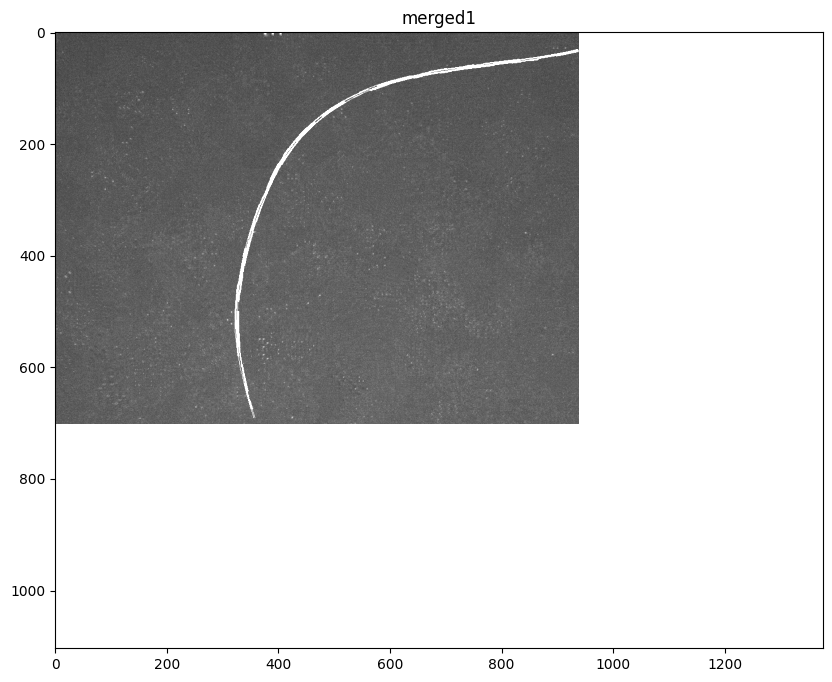

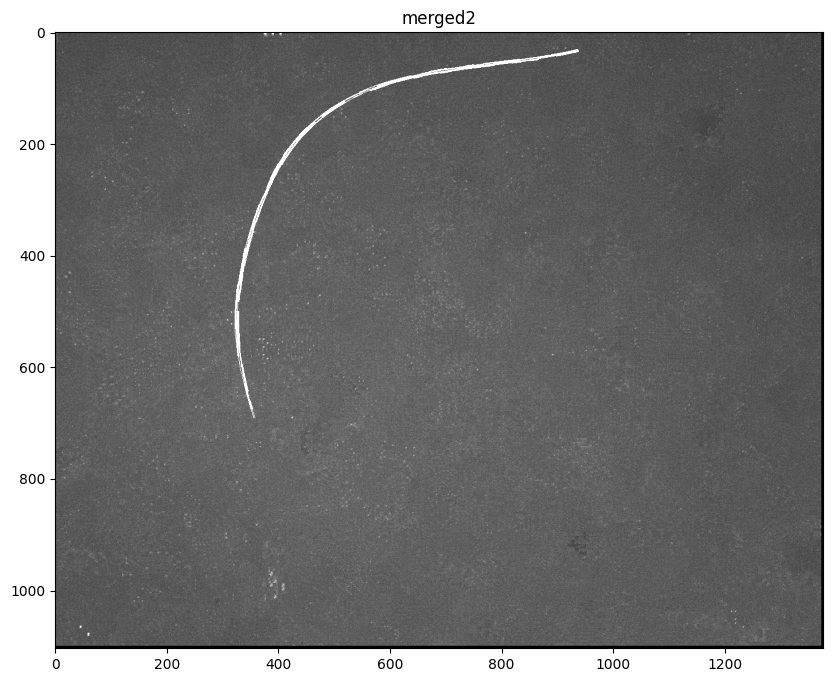

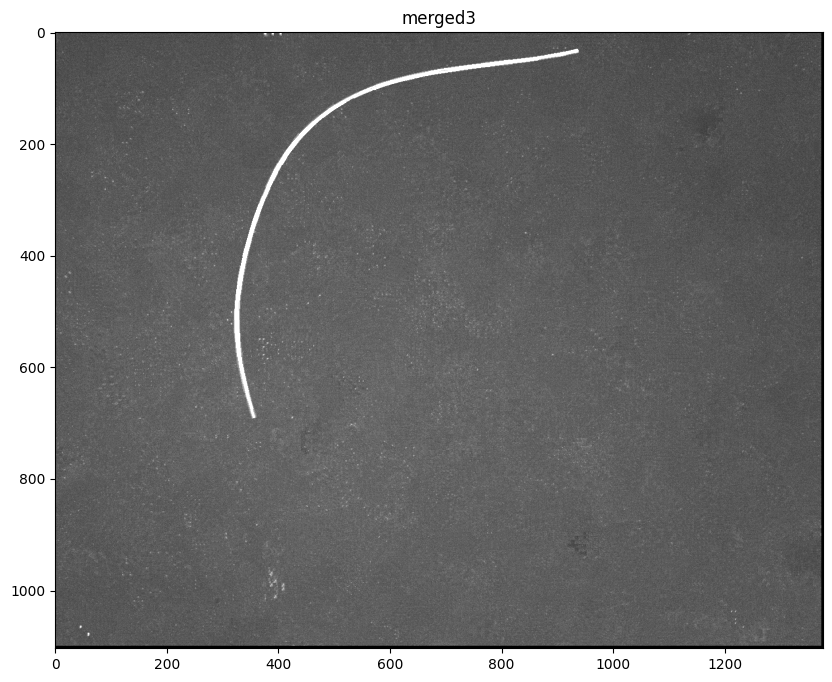

In [4]:
# img_teste = np.zeros(back_artif.shape)
# img_teste[limiar_mask] = background[limiar_mask]
plt.figure(figsize=[10, 8])
plt.title("merged1")
plt.imshow(merged1, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("merged2")
plt.imshow(merged2, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("merged3")
plt.imshow(merged3, 'gray', vmin=0, vmax=60)
plt.plot()

### Testes com o novo inserir mapa

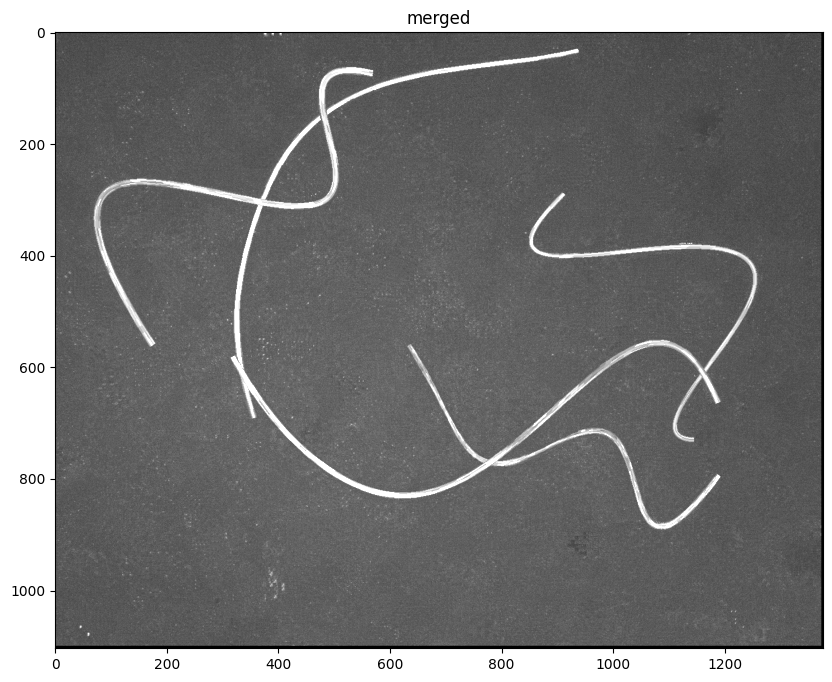

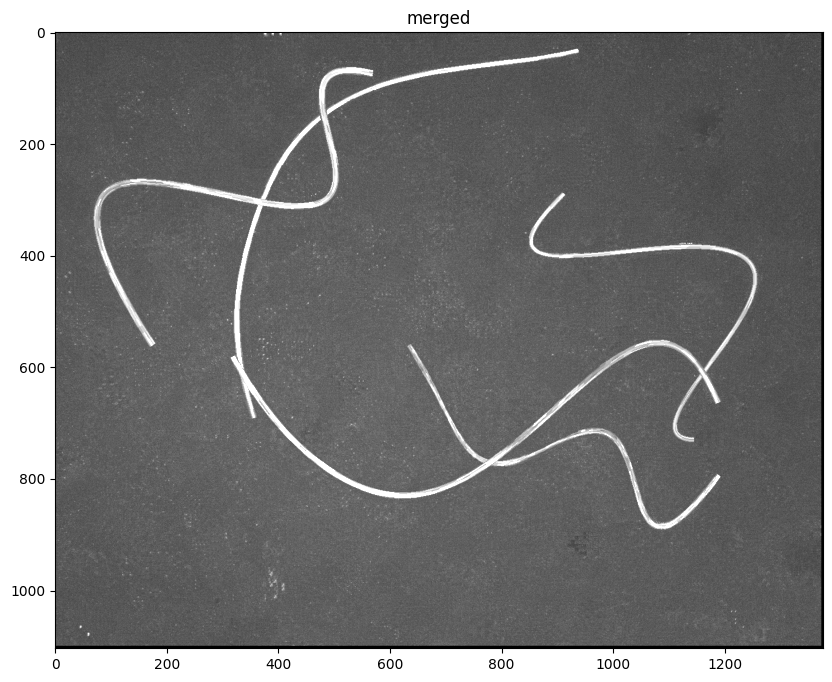

In [5]:
background = back_artif.copy()
merged = background.copy()#.astype('float64') 
merged_norm = background.copy()#.astype('float64')
merged_norm_random = background.copy()#.astype('float64') 
merged_transf = background.copy()#.astype('float64') 
merged_hist = background.copy()#.astype('float64') 
possui_mapas =  np.full(shape = background.shape, fill_value=0)

for i in range(5):
    img_vaso_bin = vetor_vasos_sem_artefados[i]
    img_mapa = vetor_mapas_sem_artefatos[i]   
    img_mapa_bin = vetor_mask_map[i]
    limiar = vetor_limiares1[i]
    
    # img_mapa_norm = backgen.normaliza(background,img_mapa,img_vaso_bin)
    # img_mapa_norm_random = backgen.merge(background,img_mapa,img_vaso_bin,0.5)
    # #img_mapa_transf = backgen.transf_map_dist(img_mapa,img_mapa_bin,img_vaso_bin,background)
    # img_mapa_hist = backgen.histograma_matching(img_mapa,img_vaso_bin,background)
    
    # plt.figure(figsize=[20, 16])
    # plt.subplot(2,2,1)
    # plt.title("merged")
    # plt.imshow(merged, 'gray', vmin=0, vmax=60)
    # plt.subplot(2,2,2)
    # plt.title("img_vaso_bin")
    # plt.imshow(img_vaso_bin, 'gray', vmin=0, vmax=1)
    # plt.subplot(2,2,3)
    # plt.title("img_mapa")
    # plt.imshow(img_mapa, 'gray', vmin=0, vmax=60)
    # plt.subplot(2,2,4)
    # plt.title("img_mapa_bin")
    # plt.imshow(img_mapa_bin, 'gray', vmin=0, vmax=1)  
    
    
    merged = backgen.inserir_mapa(merged,img_vaso_bin,img_mapa,img_mapa_bin, limiar, possui_mapas)
    # plt.figure(figsize=[20, 16])
    # plt.subplot(2,2,1)
    # plt.title("merged")
    # plt.imshow(merged, 'gray', vmin=0, vmax=60)
    # plt.subplot(2,2,2)
    # plt.title("img_vaso_bin")
    # plt.imshow(img_vaso_bin, 'gray', vmin=0, vmax=1)
    # plt.subplot(2,2,3)
    # plt.title("img_mapa")
    # plt.imshow(img_mapa, 'gray', vmin=0, vmax=60)
    # plt.subplot(2,2,4)
    # plt.title("img_mapa_bin")
    # plt.imshow(img_mapa_bin, 'gray', vmin=0, vmax=1)
    
    
    
    # merged_norm = backgen.inserir_mapa(merged_norm,img_vaso_bin,img_mapa_norm,img_mapa_bin, limiar, possui_mapas.copy())
    # merged_norm_random = backgen.inserir_mapa(merged_norm_random,img_vaso_bin,img_mapa_norm_random,img_mapa_bin, limiar, possui_mapas.copy())
    # #merged_transf = backgen.inserir_mapa(merged_norm,img_vaso_bin,img_mapa_transf,img_mapa_bin, limiar, possui_mapas)
    # merged_hist = backgen.inserir_mapa(merged_hist,img_vaso_bin,img_mapa_hist,img_mapa_bin, limiar, possui_mapas.copy())
    # #merged_new = backgen.inserir_mapa(merged_new,img_vaso_bin,img_map_final,img_mapa_bin, limiar, possui_mapas)

# Calcular a média onde há cruzamentos

plt.figure(figsize=[10, 8])
plt.title("merged")
plt.imshow(merged, 'gray', vmin=0, vmax=60)
plt.plot()
#merged = merg.copy()
#merged[possui_mapas>0] = merged[possui_mapas>0] / possui_mapas[possui_mapas>0]
# merged_norm[possui_mapas>0] = merged_norm[possui_mapas>0] / possui_mapas[possui_mapas>0]
# merged_norm_random[possui_mapas>0] = merged_norm_random[possui_mapas>0] / possui_mapas[possui_mapas>0]
# #merged_transf[possui_mapas>0] /= possui_mapas[possui_mapas>0]
# merged_hist[possui_mapas>0] =  merged_hist[possui_mapas>0] / possui_mapas[possui_mapas>0]

plt.figure(figsize=[10, 8])
plt.title("merged")
plt.imshow(merged, 'gray', vmin=0, vmax=60)
plt.plot()

img1 = Image.fromarray(merged.astype(np.uint8))

img = img1.save("teste2.tiff")

# plt.figure(figsize=[10, 8])
# plt.title("merged normalizado")
# plt.imshow(merged_norm, 'gray', vmin=0, vmax=60)
# plt.plot()

# plt.figure(figsize=[10, 8])
# plt.title("merged random")
# plt.imshow(merged_norm_random, 'gray', vmin=0, vmax=60)
# plt.plot()

# # plt.figure(figsize=[10, 8])
# # plt.title("merged_new")
# # plt.imshow(merged_transf, 'gray', vmin=0, vmax=60)
# # plt.plot()

# plt.figure(figsize=[10, 8])
# plt.title("merged histograma")
# plt.imshow(merged_hist, 'gray', vmin=0, vmax=60)
# plt.plot()

### Testes para fazer o novo inserir mapa

[]

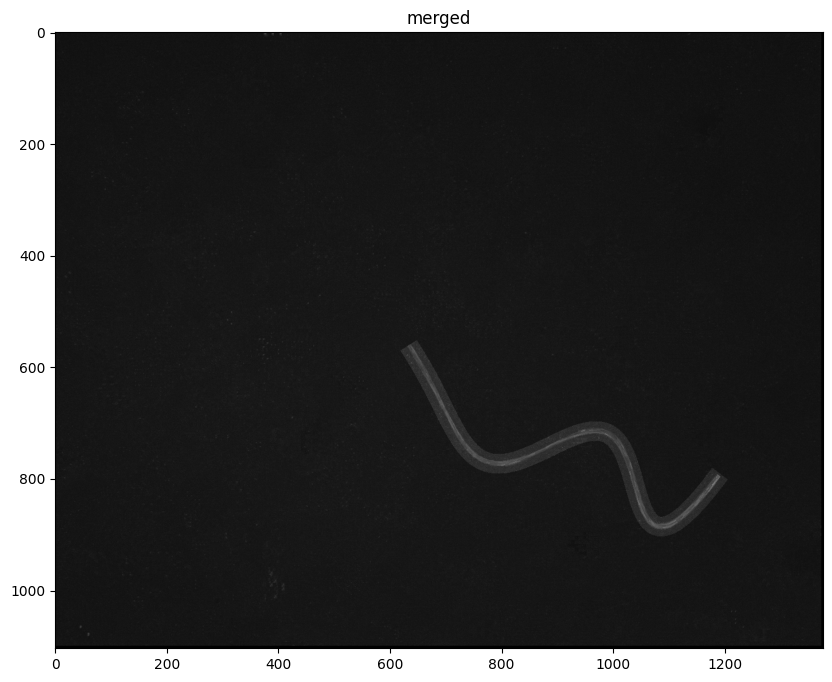

In [6]:
i = 3
merged = background.copy().astype('float64') 
img_vaso_bin = vetor_vasos_sem_artefados[i]
img_mapa = vetor_mapas_sem_artefatos[i] 
#img_mapa = img_mapa1.copy()#.astype('uint8') 
img_mapa_bin = vetor_mask_map[i]
possui_mapas_new =  np.full(shape = background.shape, fill_value=0)

limiar1 = vetor_limiares1[i]
limiar2 = vetor_limiares2[i]    

#img_back = img_mapa.copy()
rows, cols = img_mapa.shape

limiar_mask = (img_mapa <= limiar1) & (img_mapa_bin == 1) & (img_vaso_bin == 0)

img_mapa[limiar_mask] = background[0:rows,0:cols][limiar_mask]

pix_map = np.nonzero(img_mapa_bin)
possui_mapas_new[pix_map] += 1

merged[pix_map] += img_mapa[pix_map]

merged_1= merged.copy().astype('float64')

merged[possui_mapas_new>0] /= possui_mapas_new[possui_mapas_new>0]

plt.figure(figsize=[10, 8])
plt.title("merged")
plt.imshow(merged, 'gray', vmin=0, vmax=255)
plt.plot()

### Transformada da distância

In [7]:
img_map_final = backgen.transf_map_dist(mapa_sem_artefatos,mask_map,vaso_binario_rotacionado,back_artif)

print(mapa_sem_artefatos.shape)

print(img_map_final.shape)

(704, 941)
(704, 941)


### Salvando o fundo

In [8]:
img = merged.copy()
img1 = Image.fromarray(img/255)

img = img1.save("teste1.tiff")


### Plots dos mapas

/tmp/ipykernel_7568/4209089503.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(vetor_mapas_sem_artefatos),i+1)
/tmp/ipykernel_7568/4209089503.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(vetor_mapas_originais_norm),i+1)
/tmp/ipykernel_7568/4209089503.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(vetor_mapas_originais_merge_norm_random),i+1)
/tmp/ipykernel_7568/4209089503.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() a

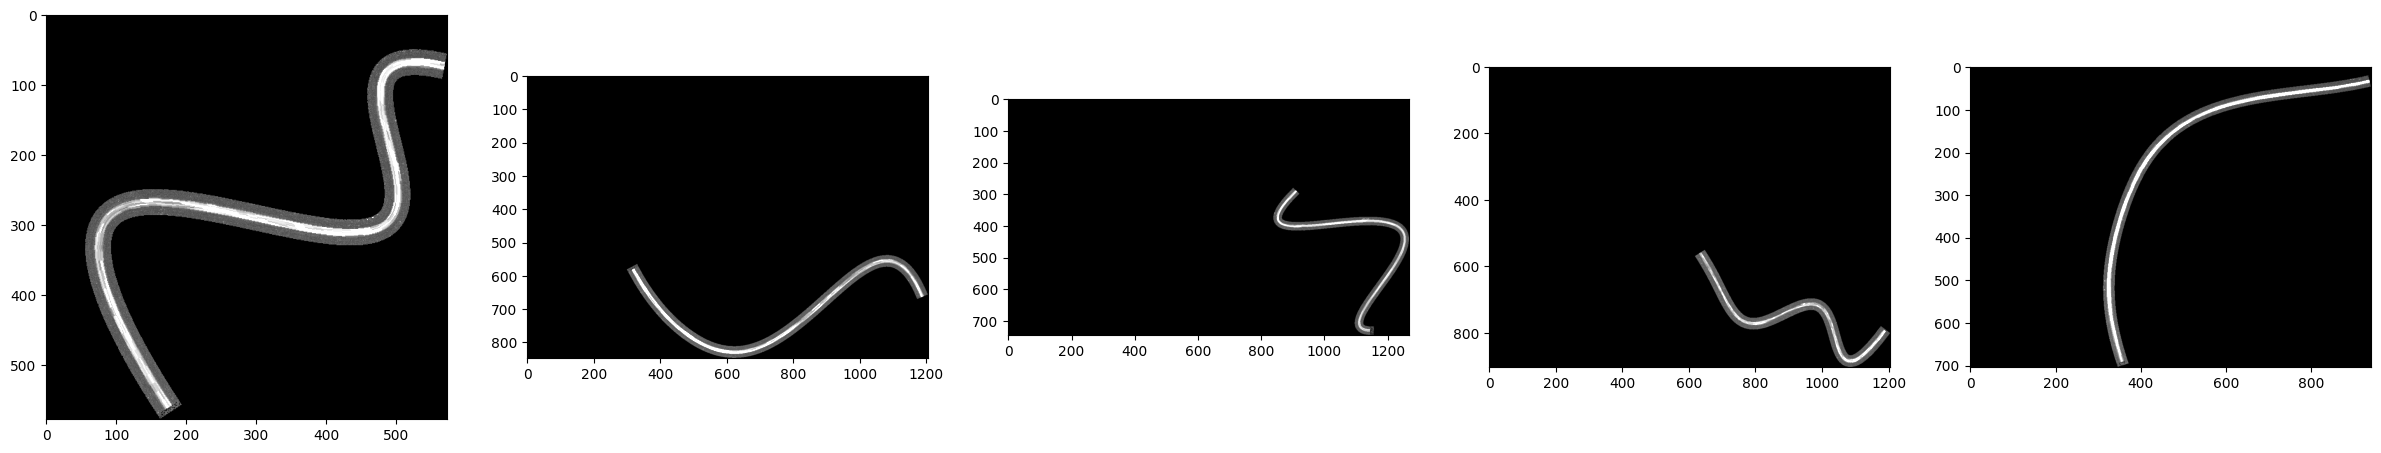

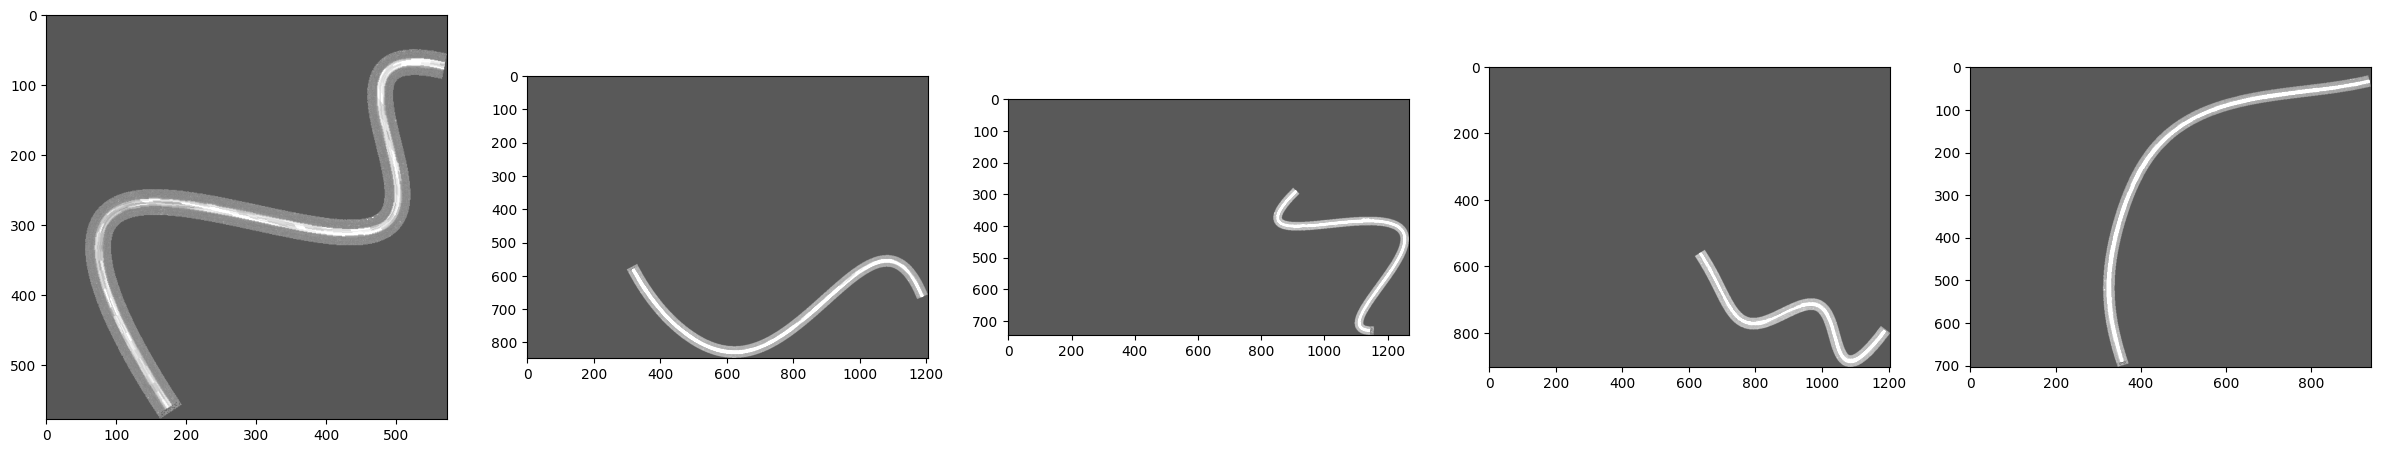

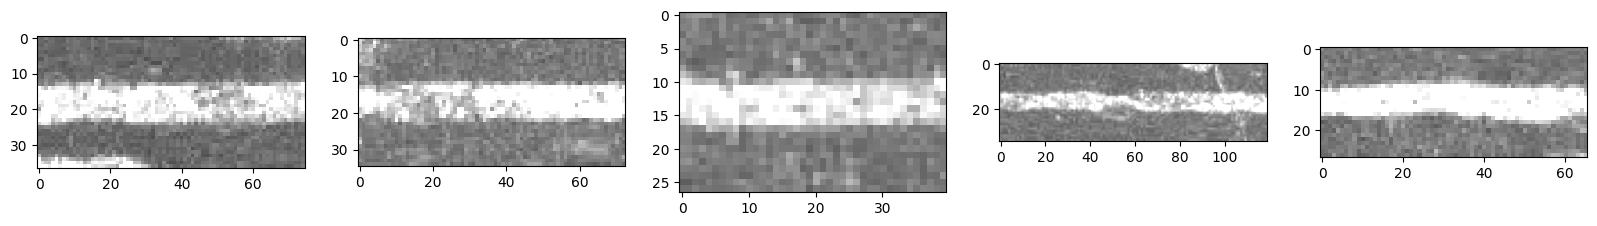

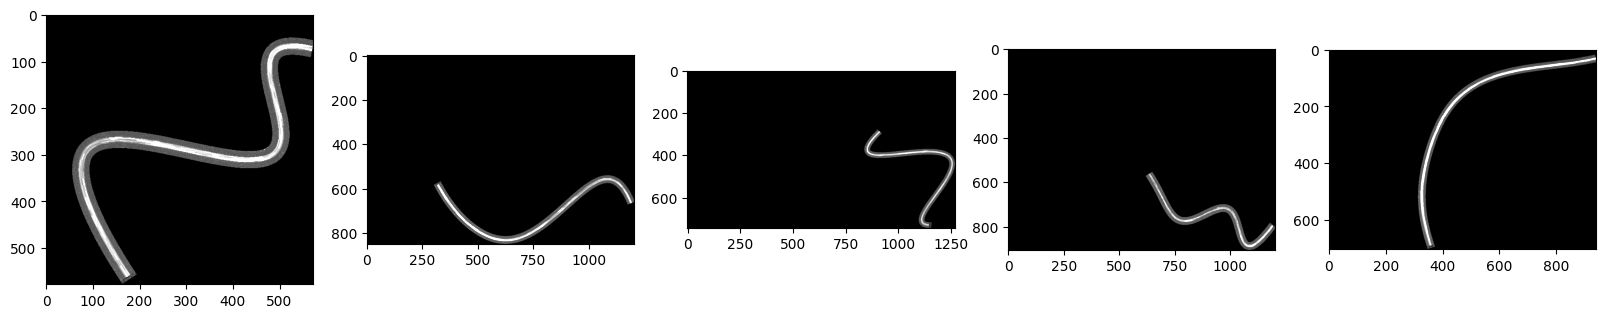

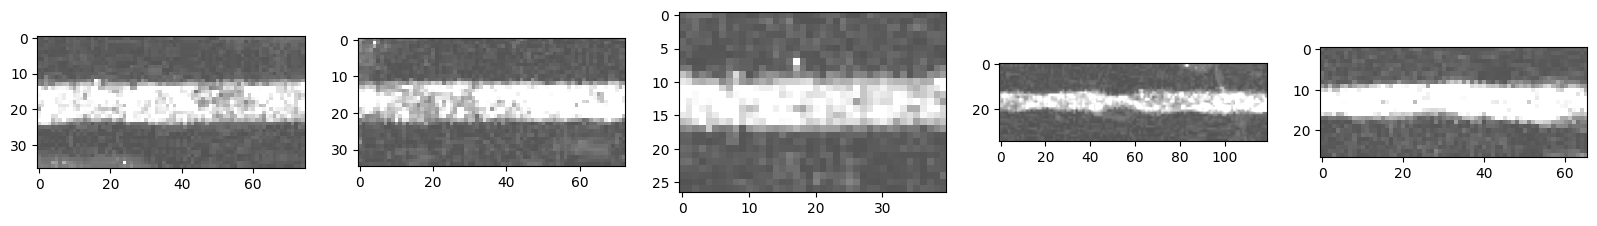

In [9]:

# plt.figure(figsize=[10, 8])
# plt.title("fundo com vaso")
# plt.imshow(img, 'gray', vmin=0, vmax=60)
# plt.plot()

plt.figure(figsize=[30, 30])
plt.title("mapa_sem_artefatos")
for i in range(len(vetor_mapas_sem_artefatos)):  
    plt.subplot(1,len(vetor_mapas_sem_artefatos),i+1)  
    plt.imshow(vetor_mapas_sem_artefatos[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[30, 30])
plt.title("Mapas normalizados")
for i in range(len(vetor_mapas_originais_norm)):  
    plt.subplot(1,len(vetor_mapas_originais_norm),i+1)  
    plt.imshow(vetor_mapas_originais_norm[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[20, 16])
for i in range(len(vetor_mapas_originais)):    
    plt.subplot(1,len(vetor_mapas_originais),i+1)    
    plt.imshow(vetor_mapas_originais[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[20, 16])
plt.title("Mapas mergeados e normalizados")
for i in range(len(vetor_mapas_originais_merge_norm_random)):  
    plt.subplot(1,len(vetor_mapas_originais_merge_norm_random),i+1)  
    plt.imshow(vetor_mapas_originais_merge_norm_random[i], 'gray', vmin=0, vmax=60)
    
plt.figure(figsize=[20, 16])
plt.title("vetor_mapa_original_hist")
for i in range(len(vetor_img_map_hist)):  
    plt.subplot(1,len(vetor_img_map_hist),i+1)  
    plt.imshow(vetor_img_map_hist[i], 'gray', vmin=0, vmax=60)



### Plots dos traçados

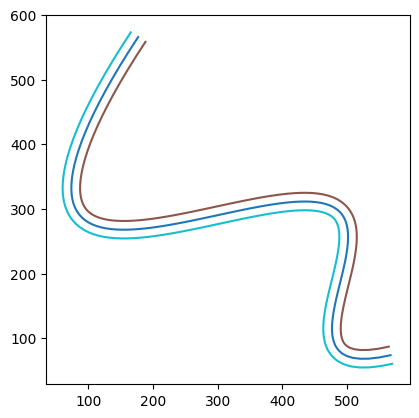

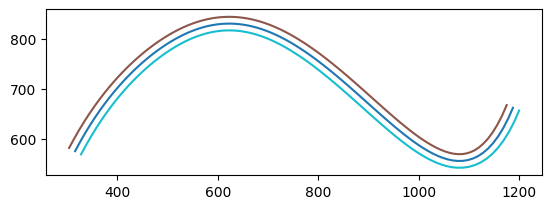

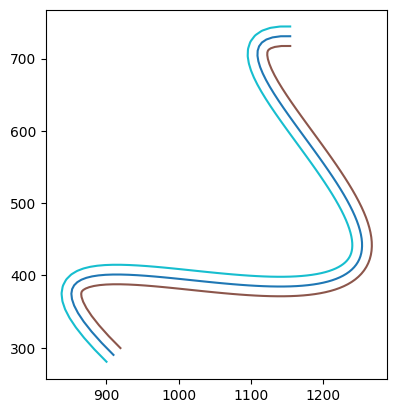

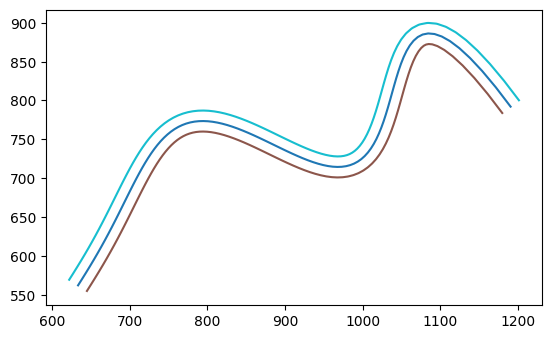

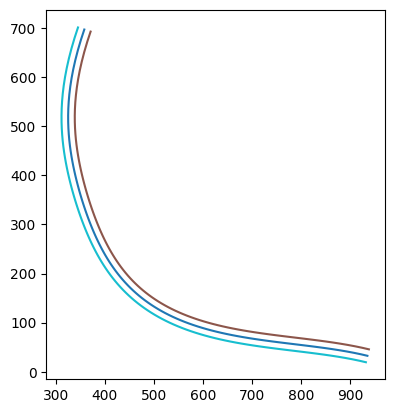

In [10]:
for i in range(len(array_medial_path)):    
    #caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(array_medial_path[i], 2) # type: ignore

    linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_medial_path[i],distancia)

    gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])
    gp4.plot(cmap="tab10")

### Testes com inserindo vaso no fundo

[]

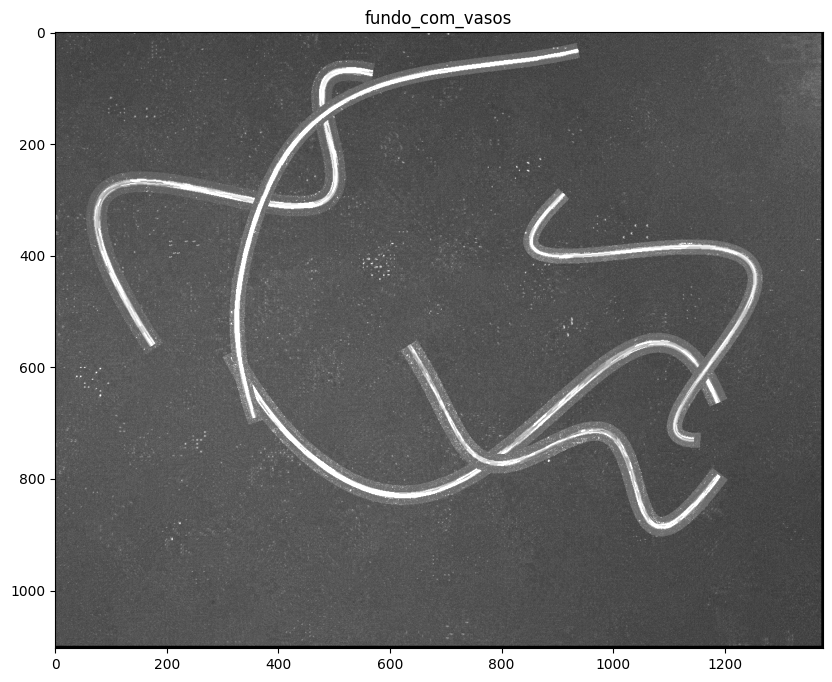

In [11]:
 
back_artif = np.array(Image.open(f'{background_dir}/{array_backgrounds[4]}'))


fundo_com_vasos = back_artif.copy()
for i in range(5):
    img_teste = backgen.histograma_matching(vetor_mapas_sem_artefatos[i], vetor_vasos_sem_artefados[i],back_artif) 
    fundo_com_vasos = backgen.inserindo_vaso_no_fundo(img_teste, vetor_mask_map[i], fundo_com_vasos, (0,0))  



plt.figure(figsize=[10, 8])
plt.title("fundo_com_vasos")
plt.imshow(fundo_com_vasos, 'gray', vmin=0, vmax=60)
plt.plot()

In [12]:
path = (pickle_dir + f'/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata2.pickle')


arquivo_pickle = pickle.load(open(path, 'rb')) 
vessel_map = arquivo_pickle['vessel_model'].vessel_map 
mapa_original = vessel_map.mapped_values
mapa_original.shape

(27, 54)

In [13]:

# img_fundo = back_artif.copy()

# #transf_map_dist(img_map,img_map_bin,img_vaso_bin,img_fundo)


# img_vaso_bin = vaso_binario_rotacionado
# img_map = mapa_sem_artefatos
# img_map_bin = mask_map
    



# fundo_com_vasos = back_artif.copy()
# for i in range(5):
#     fundo_com_vasos = backgen.inserindo_vaso_no_fundo(img_map_final, img_map_bin, fundo_com_vasos, (0,0))  

# plt.figure(figsize=[10, 8])
# plt.title("fundo_com_vasos")
# plt.imshow(fundo_com_vasos, 'gray', vmin=0, vmax=60)
# plt.plot()

### Exibe os backgrounds

In [14]:
# for i in range(len(array_backgrounds)):
#    back_artif = np.array(Image.open(f'{background_dir}/{array_backgrounds[i]}'))
#    plt.figure(figsize=[10, 8])
#    plt.title(f'{array_backgrounds[i]}')
#    plt.imshow(back_artif, 'gray', vmin=0, vmax=60)
#    plt.plot()
  


In [15]:
f'{background_dir}/{array_backgrounds[n_backgrounds]}'

'/home/adriano/projeto_mestrado/modules/Background/Mapas_gerados_artificialmente/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@69-Image 3-20X.tiff'